# AI for Beginners: Crafting a Chatbot to Transform Customer Service

## 1) Introduction

### 1.1) Chatbots in Customer Service
- Chatbots help out with simple stuff, giving customer service reps more time for tricky issues.
- Customers get quick answers to basic questions without waiting for a human rep.
- Chatbots can be the initial contact point that ensures all the information required from the customer is available


### 1.2) Alternatives to Chatbots
- Human support (costly and may not be 24/7)
- Community forums (not necessarily accurate, may not properly represent the brand)
- Videos/tutorials/FAQs (may not be comprehensive, may need to look in multiple places to get the complete answer)

### 1.3) Implementing a chatbot with an LLM
- Data cleaning, storage, retrival, formatting
- Prompts
- Embeddings
- LLM
- Conversation memory
- Completion

<div style="display: flex;">
  <div style="flex: 1;">
    <img src="images/llm.png" alt="LLM with vectorstore">
  </div>
</div>

<div style="display: flex;">
  <div style="flex: 1;">
    <img src="images/llm_with_vectorstore.png" alt="LLM with vectorstore">
  </div>
</div>

## 2) Setup the environment

* VSCode
* VSCode extensions
* Get OpenAI API keys
* pip requirements
* Install the necessary libraries

In [30]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import re
import plotly.graph_objects as go
import numpy as np
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

True

## 3) Prep the data

<div style="display: flex;">

  <div style="flex: 1;">
    <ul>
      <li>Get data from Kaggle</li>
      <li>Clean data</li>
      <li>Organize into chat inputs</li>
      <li>Exploratory Data Analysis</li>
    </ul>
  </div>

  <div style="flex: 1;">
    <!-- <h3>Embedding databases</h3> -->
    <p><img src="images/support_conversations.png" alt="CRM support conversations" style="width: 100%;"/></p>
  </div>

</div>

In [43]:
# https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
# /kaggle/input/customer-support-on-twitter/twcs/twcs.csv

def extract_company(row):
    if not row['inbound']:
        return row['author_id']
    else:
        match = re.search(r"@(\w+)", row['text'])
        if match:
            return match.group(1)
        else:
            return None

def get_tweets_df(csv_file):
    tweets = pd.read_csv(csv_file, encoding='utf-8')
    
    # Fill missing values with -1
    tweets['in_response_to_tweet_id'] = tweets['in_response_to_tweet_id'].fillna(-1)
    tweets['response_tweet_id'] = tweets['response_tweet_id'].fillna(-1)

    tweets['in_response_to_tweet_id'] = tweets['in_response_to_tweet_id'].astype(int)

    # Add a new column for the associated company
    tweets['company'] = tweets.apply(extract_company, axis=1)

    return tweets

csv_file = './input/twcs/twcs_tail.csv'
# csv_file = './input/twcs/sample.csv'
tweets = get_tweets_df(csv_file)
print(f"tweets: {tweets.shape}")
tweets.head(5)



tweets: (35026, 8)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company
0,2917710,740946,True,Tue Nov 28 23:46:57 +0000 2017,.@115873 if I get a 1-star rating from a passe...,2917708,-1,115873
1,2917714,Uber_Support,False,Wed Nov 29 00:25:55 +0000 2017,@291914 We're here to help! Send us a DM with ...,-1,456807,Uber_Support
2,456807,291914,True,Wed Nov 29 00:23:49 +0000 2017,@McDonalds @115877 Yeah. Your ad needs fixing ...,2917714,456625,McDonalds
3,2917715,Uber_Support,False,Wed Nov 29 00:24:21 +0000 2017,@605407 Here to help. Send us a note at https:...,2917716,2917717,Uber_Support
4,2917716,605407,True,Wed Nov 29 00:28:42 +0000 2017,@Uber_Support this feels like a really slow pr...,2917718,2917715,Uber_Support


### Convert the dataframe into conversation threads

In [44]:
def get_conversation_threads(tweet_id, df, company=None):
    conversation = []
    timestamps = []
    inbound_status = []

    while tweet_id:
        rows = df.loc[df['tweet_id'] == tweet_id]
        if not rows.empty:
            row = rows.squeeze()

            # Filter out tweets not associated with the specified company
            if company is not None and row['company'] != company:
                tweet_id = None
                continue

            conversation.append(tweet_id)
            timestamps.append(pd.to_datetime(row['created_at']))
            inbound_status.append(row['inbound'])
            
            if pd.notna(row["response_tweet_id"]):
                tweet_id = int(str(row["response_tweet_id"]).split(',')[0])
            elif pd.notna(row["in_response_to_tweet_id"]):
                tweet_id = int(str(row["in_response_to_tweet_id"]).split(',')[0])
            else:
                tweet_id = None
        else:
            tweet_id = None

    sorted_conversation = sorted(zip(conversation, timestamps, inbound_status), key=lambda x: x[1])
    return [(tweet_id, inbound) for tweet_id, _, inbound in sorted_conversation]



specific_company = "SouthwestAir"

# Initialize an empty list to store conversation threads text
threads_text = []
for index, row in tqdm(tweets.iterrows(), total=tweets.shape[0]):

    tweet_id = row['tweet_id']
    conversation_thread = get_conversation_threads(tweet_id, tweets, specific_company)
    if len(conversation_thread)==0:
        continue

    # CONVERT INTO THE EXPECTED TEXT FORMAT
    thread_text = ""
    for chain_id, inbound in conversation_thread:
        text = tweets.loc[tweets['tweet_id'] == chain_id, 'text'].values[0]
        try:
            content = text.split(': ')[1]
        except IndexError:
            content = text
        if inbound:
            modified_text = f"USER-->\n{content}\n"
        else:
            modified_text = f"<--SUPPORT\n{content}\n"
        
        thread_text += (modified_text)

    threads_text.append(thread_text)


print(threads_text[12])

100%|██████████| 35026/35026 [00:09<00:00, 3800.87it/s]

USER-->
@SouthwestAir thanks for the ride over to LAX this evening. As always, great service. Cheers! https://t.co/Kba49stGIo
<--SUPPORT
@155613 Always a pleasure having you onboard with us, Mike. Come back and see us again soon! ^MA



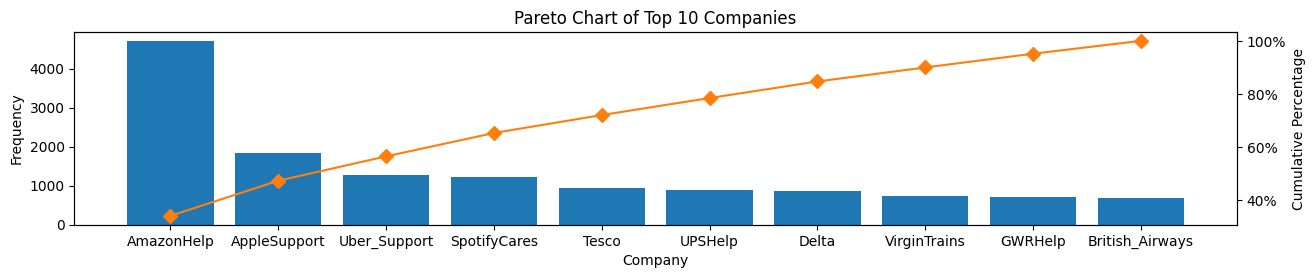

In [48]:
# EXPLORATORY DATA ANALYSIS

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
company_counts = tweets['company'].value_counts().nlargest(10)
total_counts = company_counts.sum()

cumulative_percentage = (company_counts.cumsum() / total_counts) * 100

# Plot the Pareto chart
fig, ax = plt.subplots(figsize=(15, 2.5))
ax.bar(company_counts.index, company_counts.values, color='C0')
ax2 = ax.twinx()
ax2.plot(cumulative_percentage.index, cumulative_percentage.values, color='C1', marker='D', ms=7)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x/100)))

ax.set_xlabel('Company')
ax.set_ylabel('Frequency')
ax2.set_ylabel('Cumulative Percentage')
plt.title('Pareto Chart of Top 10 Companies')
plt.show()

## 4) Embeddings

<div style="display: flex;">

  <div style="flex: 1;">
    <ul>
      <li>Embeddings are low dimensional representation of high dimensional data (like language)</li>
      <li>For the chatbot we need a lower dimensional representation of the customer support exchange</li>
      <li>We can generate embeddings with OpenAI, HuggingFace, etc.</li>
    </ul>
    <ul>
      <li>Convert conversations into embeddings</li>
      <li>Store embeddings in a vector database</li>
      <li>Convert a query to embeddings</li>
      <li>Find similar conversations to the query</li>
    </ul>
  </div>

  <div style="flex: 1;">
    <!-- <h3>Embedding databases</h3> -->
    <p><img src="images/embeddings.png" alt="Embeddings" style="width: 100%;"/></p>
  </div>

</div>

### Create the embeddings

In [49]:
import openai
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

use_openai = False
if use_openai:
   embed_model = "text-embedding-ada-002" # 1536 dimensions

   embedding_results = openai.Embedding.create(
      input=threads_text, engine=embed_model
   )

   embedding_matrix = []
   for x in embedding_results['data'] :
      embedding_matrix.append(x['embedding'])
   
   # USED FOR VISUALIZATION
   embedding_array = np.array(embedding_results)

else:

   model_name = "sentence-transformers/all-mpnet-base-v2"
   model_kwargs = {"device": "cpu"}
   hf = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)


   hf = HuggingFaceEmbeddings()
   embedding_results_hf = hf.embed_documents(threads_text)

   # USED FOR VISUALIZATION
   embedding_array = np.array(embedding_results_hf)


### Store the embeddings into a Vector Database

In [57]:
from langchain.vectorstores import FAISS

# FAISS IS IN MEMORY
# CHROMADB CAN BE INSTALLED LOCALLY
# PINECONEDB IS IN THE CLOUD

if use_openai:
   db = FAISS.from_texts(threads_text, OpenAIEmbeddings())
else:
   db = FAISS.from_texts(threads_text, HuggingFaceEmbeddings())

### Visualize the embeddings

In [58]:
import plotly.graph_objs as go
import textwrap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

visualization_type = "3d"
# visualization_type = "2d"

# Change number of components to 3
tsne = TSNE(n_components=3, random_state=0)
tsne_obj = tsne.fit_transform(embedding_array)

# Add third component to DataFrame
tsne_df = pd.DataFrame({'Component 1': tsne_obj[:, 0], 'Component 2': tsne_obj[:, 1], 'Component 3': tsne_obj[:, 2], 'Text': threads_text})

# Number of clusters you want to create
n_clusters = 10

# Perform K-means clustering on the embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding_array)

# Add the cluster labels to the t-SNE DataFrame
tsne_df['Cluster'] = kmeans.labels_

# Function to wrap text with a specified line length
def wrap_text(text, line_length=50):
    return "<br>".join(textwrap.wrap(text, width=line_length))

tsne_df['WrappedText'] = tsne_df['Text'].apply(wrap_text)

# Create a scatter plot with hover text
fig = go.Figure()

# Add a trace for each cluster
for cluster in range(n_clusters):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]

    if visualization_type == "3d":
        fig.add_trace(go.Scatter3d(
            x=cluster_data['Component 1'],
            y=cluster_data['Component 2'],
            z=cluster_data['Component 3'],  # Add the third component
            mode='markers',
            hovertemplate='%{text}',
            text=cluster_data['WrappedText'],
            name=f'Cluster {cluster}'
        ))
    else:
        fig.add_trace(go.Scatter(
            x=cluster_data['Component 1'],
            y=cluster_data['Component 2'],
            mode='markers',
            hovertemplate='%{text}',
            text=cluster_data['WrappedText'],
            name=f'Cluster {cluster}'
        ))

# Set the title for the plot
fig.update_layout(
    title='t-SNE Visualization with Clusters',
    height=800
    )

# Show the plot
fig.show()


/Users/chris/opt/anaconda3/envs/langchain_3_9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [59]:
query = "USER-->\n You lost my bag."
# filtered_docs = db_huggingface.similarity_search(query, k=10)
filtered_docs = db.similarity_search(query, k=4)
print(len(filtered_docs))
for doc in (filtered_docs):
   print(doc.page_content)


4
<--SUPPORT
@813562 Looks like you're in the right place to check that bag, Anna! Thanks for flying with us today. ^JB

<--SUPPORT
@809920 So sorry to hear that the contents of your bag were wet, Josh. Please DM us your confirmation number so we can take a closer look. ^NG https://t.co/mQmfkYdFNv

USER-->
Thank you @SouthwestAir for ending my Thanksgiving vacation on a low note around 1 o’clock this morning. (This was literally the first time this bag had ever been used.) https://t.co/OaGeZrntMB
<--SUPPORT
@807754 That’s not what we like to see. Did you file a bag report at the airport? ^NC
USER-->
@SouthwestAir No. It was after 1 am and I had work this morning. It seemed like waiting around for someone to fill out a complaint wouldn’t be as beneficial as getting home and sleeping.
<--SUPPORT
@807754 Please DM us your confirmation number so we can follow-up with you. ^NC

USER-->
Jokes on your Snapchat Bitmoji, I checked my bag. Thanks @SouthwestAir https://t.co/IHkK9Jcqfs
<--SUPPORT


## 5) Prompts

<div style="display: flex;">
  <div style="flex: 1;">
    <ul>
      <li>Give some context on how the LLM should represent itself (customer support agent)</li>
      <li>Provide some examples on how to answer the question</li>
    </ul>
  </div>

  <div style="flex: 1;">
    <!-- <h3>Embedding databases</h3> -->
    <p><img src="images/prompt.png" alt="Prompt" style="width: 100%;"/></p>
  </div>

</div>

### Prompt without memory

In [62]:
# SEE HOW MUCH THIS WILL COST
import tiktoken

#TODO: USE THE CORRECT MODEL
tokenizer = tiktoken.get_encoding('p50k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

from langchain import PromptTemplate


template = """
You are a friendly and helpful customer support representative. 
You have been tasked with helping a customer answer a question or resolve an issue they are having.

Here is their query:
{question}

Here are some previous questions and answers that may be helpful to you:
{references}
"""

prompt = PromptTemplate(
    input_variables=["question", "references"],
    template=template,
)

question = "USER-->\n You lost my bag."

references = ""
filtered_docs = db.similarity_search(question, k=10)
for doc in (filtered_docs):
   references+=(doc.page_content)+"\n"


# JUST FOR PRINTING
if 1:
    prompt_string = prompt.format(question=question, references=references)
    print(prompt_string)


You are a friendly and helpful customer support representative. 
You have been tasked with helping a customer answer a question or resolve an issue they are having.

Here is their query:
USER-->
 You lost my bag.

Here are some previous questions and answers that may be helpful to you:
<--SUPPORT
@813562 Looks like you're in the right place to check that bag, Anna! Thanks for flying with us today. ^JB

<--SUPPORT
@809920 So sorry to hear that the contents of your bag were wet, Josh. Please DM us your confirmation number so we can take a closer look. ^NG https://t.co/mQmfkYdFNv

USER-->
Thank you @SouthwestAir for ending my Thanksgiving vacation on a low note around 1 o’clock this morning. (This was literally the first time this bag had ever been used.) https://t.co/OaGeZrntMB
<--SUPPORT
@807754 That’s not what we like to see. Did you file a bag report at the airport? ^NC
USER-->
@SouthwestAir No. It was after 1 am and I had work this morning. It seemed like waiting around for someone 

## 6) LLM Question answering
<div style="display: flex;">

  <div style="flex: 1;">
    <ul>
      <li>Provide the prompt</li>
      <li>Choose a model</li>
      <li>Answer the question</li>
    </ul>
  </div>

  <div style="flex: 1;">
    <p><img src="images/llm_highlighted.png" alt="" style="width: 100%;"/></p>
  </div>

</div>

In [63]:
from langchain.llms import OpenAI
from langchain import LLMChain


question = "USER-->\n You lost my bag."

# USE THE GPT 3.5 MODEL
# model_names = ["gpt-3.5-turbo", "gpt-4", "text-davinci-003"]
model_names = ["gpt-3.5-turbo"]

for model_name in model_names:

   llm = OpenAI(model_name=model_name)
   token_count = tiktoken_len(prompt.format(question=question, references=references))

   answer_chain = LLMChain(llm=llm, prompt=prompt, verbose=False)
   response = answer_chain.run(question=question, references=references)
   print(f"Model name: {model_name} Tokens: {token_count} Response: {response}")


/Users/chris/opt/anaconda3/envs/langchain_3_9/lib/python3.9/site-packages/langchain/llms/openai.py:169: UserWarning:

You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`

/Users/chris/opt/anaconda3/envs/langchain_3_9/lib/python3.9/site-packages/langchain/llms/openai.py:687: UserWarning:

You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`



Model name: gpt-3.5-turbo Tokens: 1117 Response: <--SUPPORT
Hello, I apologize for any inconvenience caused. Can you please provide me with your confirmation number so I can check the status of your bag and see what we can do to help? ^HP


## 7) Conversation memory
<div style="display: flex;">

  <div style="flex: 1;">
    <ul>
      <li>Chatbots must track the back-and-forth conversation</li>
      <li>Many, many approaches to providing a summary of the conversation history</li>
      <li>Answer the question</li>
    </ul>
  </div>

  <div style="flex: 1;">
    <p><img src="images/memory.png" alt="" style="width: 100%;"/></p>
  </div>

</div>

### Prompt with conversation history

In [64]:
from langchain import PromptTemplate


# ADD THE HISTORY TO THE PROMPT TEMPLATE
template = """
You are a friendly and helpful customer support representative. 
You have been tasked with helping a customer answer a question or resolve an issue they are having.
Only use information from teh previous questions and answers to help you answer the customer's question.

Here is the conversation history up to this point:
{history}

Here is their new query:
{question}

Here are some previous questions and answers that may be helpful to you:
{references}
"""

prompt = PromptTemplate(
    input_variables=["history", "question", "references"],
    template=template,
)


references = ""
filtered_docs = db.similarity_search(question, k=10)
for doc in (filtered_docs):
   references+=(doc.page_content)+"\n"

history = ""
history += question + "\n"
history += response + "\n"

# JUST FOR PRINTING
if 1:
    second_question = "I still haven't heard anything. How do I contact them?"
    prompt_string = prompt.format(history=history, question=second_question, references=references)
    print(prompt_string)


You are a friendly and helpful customer support representative. 
You have been tasked with helping a customer answer a question or resolve an issue they are having.
Only use information from teh previous questions and answers to help you answer the customer's question.

Here is the conversation history up to this point:
USER-->
 You lost my bag.
<--SUPPORT
Hello, I apologize for any inconvenience caused. Can you please provide me with your confirmation number so I can check the status of your bag and see what we can do to help? ^HP


Here is their new query:
I still haven't heard anything. How do I contact them?

Here are some previous questions and answers that may be helpful to you:
<--SUPPORT
@813562 Looks like you're in the right place to check that bag, Anna! Thanks for flying with us today. ^JB

<--SUPPORT
@809920 So sorry to hear that the contents of your bag were wet, Josh. Please DM us your confirmation number so we can take a closer look. ^NG https://t.co/mQmfkYdFNv

USER-->

### LLM with conversation history

In [65]:


second_question = "I still haven't heard anything. How do I contact them?"

# USE THE GPT 3.5 MODEL
llm = OpenAI(model_name="gpt-3.5-turbo")
token_count = tiktoken_len(prompt.format(question=second_question, references=references, history=history))

answer_chain = LLMChain(llm=llm, prompt=prompt, verbose=False)
response = answer_chain.run(question=second_question, references=references, history=history)
print(f"Model name: {model_name} Tokens: {token_count} Response: {response}")

/Users/chris/opt/anaconda3/envs/langchain_3_9/lib/python3.9/site-packages/langchain/llms/openai.py:169: UserWarning:

You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`

/Users/chris/opt/anaconda3/envs/langchain_3_9/lib/python3.9/site-packages/langchain/llms/openai.py:687: UserWarning:

You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`



Model name: gpt-3.5-turbo Tokens: 1208 Response: To contact our Baggage Team for an update on the status of your bag, you can call our customer support hotline or send us a direct message with your confirmation number. We apologize for any inconvenience and appreciate your patience while we work on locating your missing bag. Thank you for flying with us. ^HP


## 7) Conclusion

* Built a chatbot that
   * Brings in preexisting knowledge through a vector database
   * Sets the context as a 'friendly and helpful customer support representative'
   * Remembers the conversation with memory
   * Answers the question using an LLM

* Extensions
   * Agents may be required to perform actions rather than just responses
   * Personalized system (funny, serious, passive-aggressive)
   * Integrations with CRM

## 8) Q&A